# OVERVIEW

Credit scoring merupakan proses evaluasi kelayakan kredit seseorang atau entitas berdasarkan data historis dan karakteristik keuangan tertentu. Proses ini sangat penting bagi lembaga keuangan untuk mengukur risiko gagal bayar sebelum memberikan pinjaman. Dengan memanfaatkan teknik analisis data dan **machine learning**, **credit scoring** dapat dilakukan secara **otomatis** dan akurat, memungkinkan **pengambilan keputusan yang lebih cepat** dan objektif.


Dalam proyek ini, metrik evaluasi utama yang digunakan adalah **ROC-AUC Score**, dengan **Recall** sebagai metrik pendukung. Pemilihan ini didasarkan pada karakteristik data yang tidak seimbang (*imbalanced*), di mana hanya sekitar **1,2% dari total aplikasi** dalam dataset yang tercatat mengalami gagal bayar (*default*). Dalam situasi seperti ini, fokus pada metrik Recall menjadi penting karena bertujuan untuk memaksimalkan kemampuan model dalam mengidentifikasi applikasi berisiko tinggi, meskipun jumlahnya relatif kecil. Hal ini selaras dengan pertimbangan bisnis di sektor keuangan, di mana kegagalan dalam mendeteksi applikasi yang berpotensi gagal bayar dapat menyebabkan kerugian finansial yang signifikan. Oleh karena itu, pendekatan ini tidak hanya meningkatkan performa model secara teknis, tetapi juga mendukung pengambilan keputusan yang lebih hati-hati dan strategis dalam proses pemberian kredit.


# IMPORT LIBRARY AND DATASET

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.ticker import FuncFormatter
import math

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

import warnings
warnings.filterwarnings('ignore')

def print_data_info(df):
    dataDesc=[]
    for i in df.columns:
        unique_values = df[i].drop_duplicates()
        sample_count = min(2, len(unique_values))  # Only sample as many as available (max 2)
        samples = unique_values.sample(sample_count).values
        dataDesc.append([
            i,
            df[i].dtypes,
            df[i].isna().sum(),
            round((((df[i].isna().sum())/len(df))*100), 2),
            df[i].nunique(),
            samples
        ])


    data_info = pd.DataFrame(dataDesc, columns=[
        'Data Features',
        'Data Types',
        'Null',
        'Null Percentage',
        'Unique',
        'Unique Sample'
    ])

    # Display Info
    print(f'Rows: {df.shape[0]:,}, Column: {df.shape[1]:,}')
    print('-' * 80)
    display(data_info)

**READ DATASET**

In [6]:
df = pd.read_csv('credit_scoring.csv')
df

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
0,501000,41,13995609,5982664,0,624,0,0,-0.040
1,501001,58,13683833,3711198,0,809,0,0,0.001
2,501002,33,9417391,7172332,0,647,0,0,0.077
3,501003,45,6861811,8661056,0,450,0,0,0.038
4,501004,22,5640742,4520669,1,816,0,0,0.020
...,...,...,...,...,...,...,...,...,...
5995,506995,26,18253018,3690565,2,729,0,0,0.008
5996,506996,40,9944385,4082038,1,477,0,0,0.017
5997,506997,28,9048532,14760384,0,450,0,0,-0.054
5998,506998,51,6843160,11774594,0,561,0,0,0.026


### Penjelasan Fitur

Berikut adalah deskripsi dari masing-masing fitur yang terdapat dalam dataset:

- **application_id**: ID unik dari application atau permohonan pengajuan kredit. Kolom ini bersifat identifikasi dan tidak digunakan dalam pemodelan.
- **age**: Usia peminjam dalam tahun pada saat pengajuan kredit.
- **monthly_income**: Pendapatan bulanan peminjam.
- **loan_amount**: Jumlah pinjaman yang diajukan oleh peminjam.
- **previous_defaults**: Jumlah riwayat gagal bayar sebelumnya dari peminjam.
- **credit_score**: Skor kredit peminjam berdasarkan penilaian lembaga kredit, yang mencerminkan risiko gagal bayar secara umum.
- **default**: Label target biner yang menunjukkan apakah peminjam mengalami gagal bayar (1) atau tidak (0). Fitur ini menjadi target dalam proses pemodelan.

> **Catatan:** Fitur `leak_col_good` dan `leak_col_subtle` merupakan *feature leakage*, yang akan di-drop karena akan menyebabkan data-leakage, dan sesuai dengan instruksi tes.da data baru.


In [9]:
print_data_info(df)

Rows: 6,000, Column: 9
--------------------------------------------------------------------------------


,Data Features,Data Types,Null,Null Percentage,Unique,Unique Sample
0,application_id,int64,0,0.0,6000,"[505238, 506970]"
1,age,int64,0,0.0,39,"[50, 46]"
2,monthly_income,int64,0,0.0,6000,"[17772120, 7469534]"
3,loan_amount,int64,0,0.0,6000,"[1198777, 6447943]"
4,previous_defaults,int64,0,0.0,4,"[1, 2]"
5,credit_score,int64,0,0.0,550,"[350, 490]"
6,default,int64,0,0.0,2,"[1, 0]"
7,leak_col_good,int64,0,0.0,2,"[0, 1]"
8,leak_col_subtle,float64,0,0.0,239,"[0.09, -0.031]"


Dari informasi tersebut, tidak ditemukan adanya *missing value* ataupun *duplicated data* yang perlu untuk di-drop pada saat tahapan *data cleaning*.

# DATA PREPARATION

Pada tahapan ini dilakukan *data cleaning* sebelum tahapan EDA dan modelling. Tahapan data cleaning akan mencakup 2 aspek utama, karena tidak adanya *missing value* dan *duplicated data*, yakni
- Drop fitur leakage,
- Pengecekan anomali
- Pengecekan Outlier beserta distribusi data dari fitur

*missing value* dapat diselidiki lebih lanjut jika ditemukan adanya value 0 pada salah satu fitur.

In [13]:
df_clean = df.copy()

**DROP FITUR LEAKAGE & application_id**

Application ID di-drop karena tidak akan digunakan untuk pemodelan.

In [15]:
df_clean.drop(columns = ['leak_col_good', 'leak_col_subtle', 'application_id'], inplace=True)
df_clean

,age,monthly_income,loan_amount,previous_defaults,credit_score,default
0,41,13995609,5982664,0,624,0
1,58,13683833,3711198,0,809,0
2,33,9417391,7172332,0,647,0
3,45,6861811,8661056,0,450,0
4,22,5640742,4520669,1,816,0
...,...,...,...,...,...,...
5995,26,18253018,3690565,2,729,0
5996,40,9944385,4082038,1,477,0
5997,28,9048532,14760384,0,450,0
5998,51,6843160,11774594,0,561,0


**ANOMALIES CHECKING**

Pengecekan anomali dapat dilakukan dengan describe, karena semua fitur merupakan numerikal (kecuali default yang merupakan label). *missing value* juga dapat dideteksi dengan menggunakan describe, dengan *missing value* merupakan value 0 dari berbagai fitur.

In [17]:
df_clean.describe(include='number')

,age,monthly_income,loan_amount,previous_defaults,credit_score,default
count,6000.000000,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6000.000000
mean,40.321500,1.140386e+07,8.001122e+06,0.243667,575.979833,0.012167
std,11.300697,4.912598e+06,4.071786e+06,0.484767,158.328931,0.109639
min,21.000000,3.000310e+06,1.000794e+06,0.000000,300.000000,0.000000
25%,31.000000,7.163379e+06,4.440939e+06,0.000000,438.750000,0.000000
50%,41.000000,1.129945e+07,7.982304e+06,0.000000,577.500000,0.000000
75%,50.000000,1.573705e+07,1.153144e+07,0.000000,713.000000,0.000000
max,59.000000,1.998622e+07,1.499858e+07,3.000000,849.000000,1.000000


Dapat disumpulkan bahwa tidak ada *missing value* karena nilai minimal dari fitur age, monthly_income, loan_amount, dan credit_score, tidak nol. Selain itu, berdasarkan nilai maksimum dari tiap fitur, tidak ditemukan adanya anomali pada data. Untuk previous_default berada pada rentang 0 s.d. 3 sehingga tidak ditemukan adanya anomali.

**OUTLIER CHECKING AND DATA DISTRIBUTION**

Pengecekan outlier dilakukan dengan mengecek distribusi data menggunakan visualisasi box plot beserta histogram. Untuk previous_defaults dicek pada tahapan sebelumnya.

In [21]:
df_clean.columns

Index(['age', 'monthly_income', 'loan_amount', 'previous_defaults',
       'credit_score', 'default'],
      dtype='object')

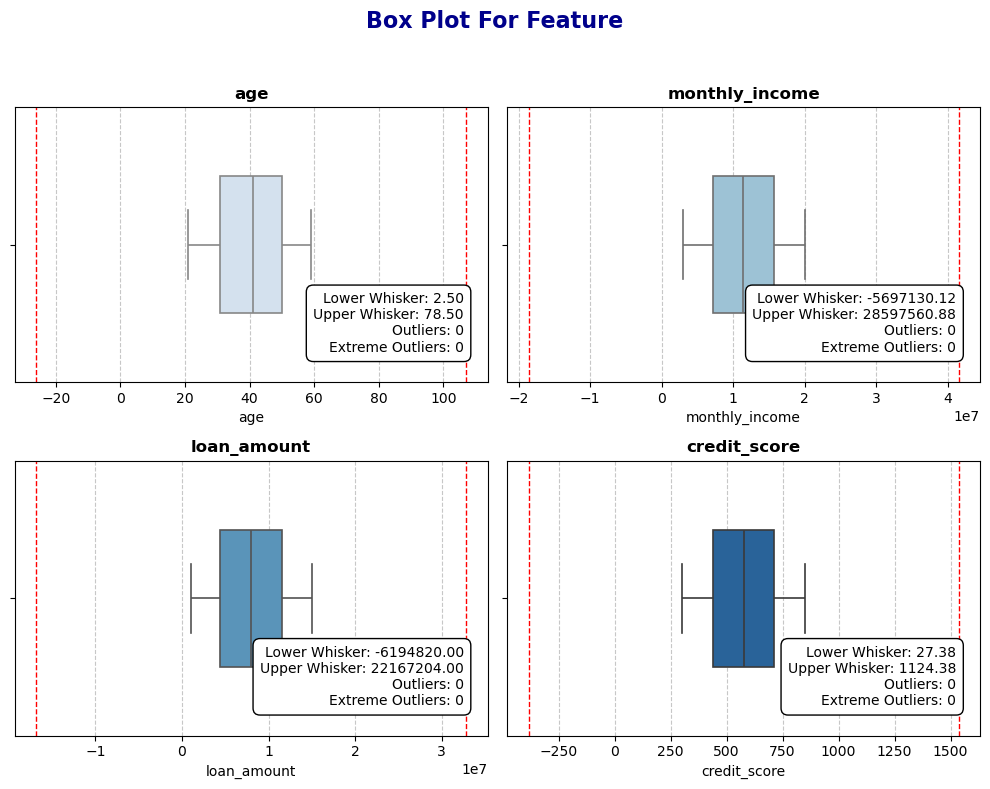

In [22]:
features = ['age', 'monthly_income', 'loan_amount', 'credit_score']
rows = (len(features) // 2) + (len(features) % 2)
cols = 2

plt.figure(figsize=(cols * 5, rows * 4))
plt.suptitle('Box Plot For Feature', fontsize=16, fontweight='bold', color='darkblue')

colors = sns.color_palette("Blues", len(features))

for idx, column in enumerate(features):
    ax = plt.subplot(rows, cols, idx + 1)
    sns.boxplot(x=df_clean[column], color=colors[idx], width=0.5, fliersize=4, linewidth=1.2)
    plt.title(column, fontsize=12, fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    q1 = df_clean[column].quantile(0.25)
    q3 = df_clean[column].quantile(0.75)
    iqr = q3 - q1
    lower_whisker = q1 - (1.5 * iqr)
    upper_whisker = q3 + (1.5 * iqr)
    extreme_lower_whisker = q1 -( 3 * iqr)
    extreme_upper_whisker = q3 + ( 3 * iqr)
    outliers = df_clean[(df_clean[column] < lower_whisker) | (df_clean[column] > upper_whisker)][column]
    extreme_outliers = df_clean[(df_clean[column] < extreme_lower_whisker) | (df_clean[column] > extreme_upper_whisker)][column]
    
    ax.axvline(extreme_lower_whisker, color='red', linestyle='--', linewidth=1)
    ax.axvline(extreme_upper_whisker, color='red', linestyle='--', linewidth=1)

    info_text = f"Lower Whisker: {lower_whisker:.2f}\nUpper Whisker: {upper_whisker:.2f}\nOutliers: {len(outliers)}\nExtreme Outliers: {len(extreme_outliers)}"
    plt.text(0.95, 0.1, info_text, transform=ax.transAxes, fontsize=10,
             verticalalignment='bottom', horizontalalignment='right',
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Berdasarkan box plot, fitur-fitur yang ada tidak memiliki outlier dan terdistribusi normal. *Standard Scaler* atau *Robust Scaler* dapat digunakan pada proses modelling. Histogram dan uji statistik akan digunakan untuk pengecekan lebih lanjut mengenai distribusi data.

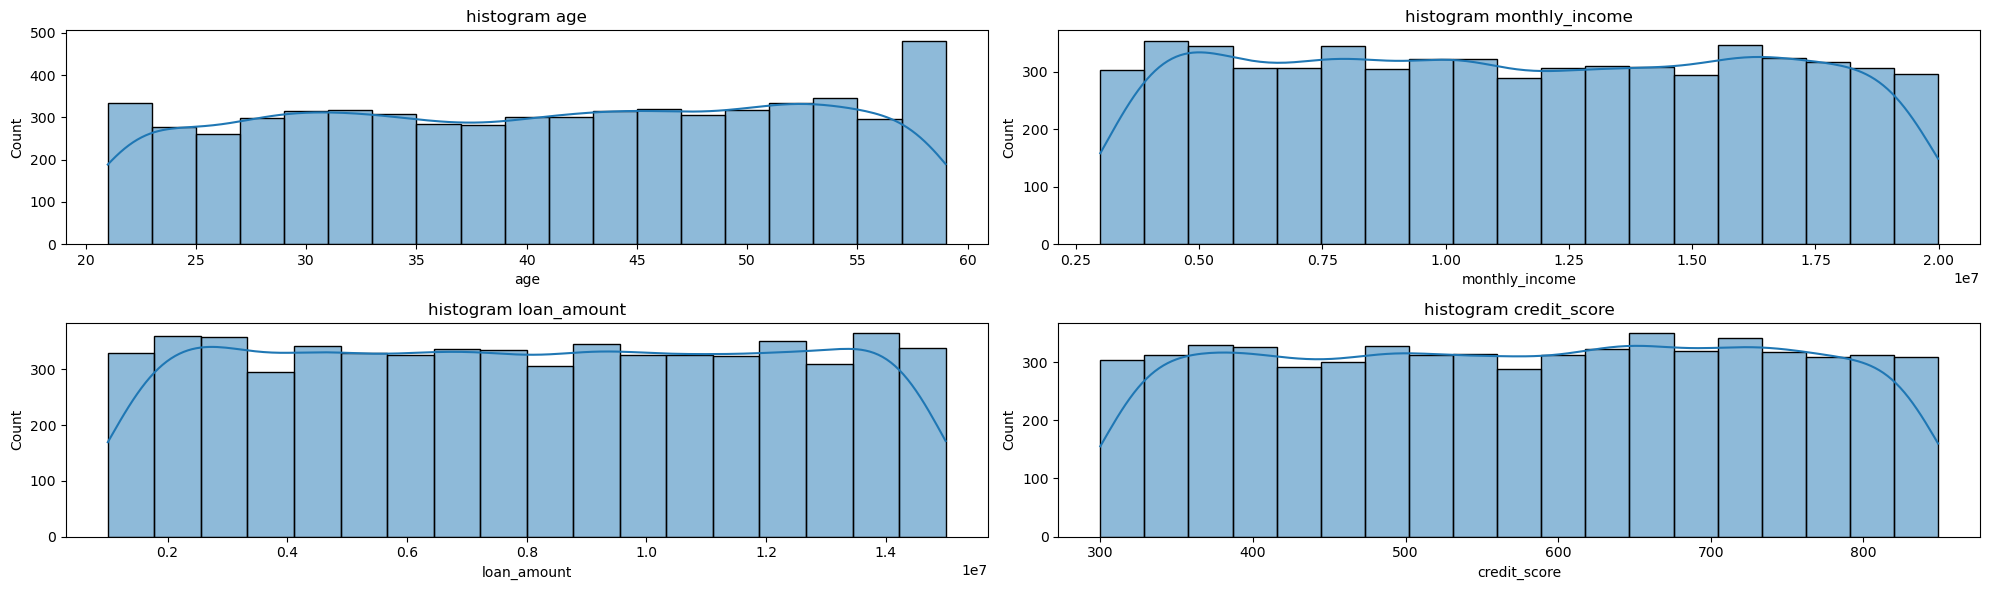

In [24]:
sum = len(features)
row = math.ceil(sum / 2)  # misalnya 2 kolom per baris

fig = plt.figure(figsize=(20,row *3)) # horizontal, vertikal

count = 0
for kolom in features:
    count += 1
    plt.subplot(row,2,count)
    sns.histplot(df_clean.select_dtypes(include='number')[kolom], kde=True)
    plt.title(f"histogram {kolom}")
    fig.tight_layout() # biar tidak tertumpuk
plt.show()

**CLEANED DATA**

Berikut merupakan data yang telah di-clean,

In [27]:
df_clean

,age,monthly_income,loan_amount,previous_defaults,credit_score,default
0,41,13995609,5982664,0,624,0
1,58,13683833,3711198,0,809,0
2,33,9417391,7172332,0,647,0
3,45,6861811,8661056,0,450,0
4,22,5640742,4520669,1,816,0
...,...,...,...,...,...,...
5995,26,18253018,3690565,2,729,0
5996,40,9944385,4082038,1,477,0
5997,28,9048532,14760384,0,450,0
5998,51,6843160,11774594,0,561,0


# DATA ANALYSIS

Tahapan EDA (Exploratory Data Analysis) akan menganalisis hubungan fitur terhadap label, yang dapat memberikan insights untuk proses pemodelan maupun untuk rekomendasi bisnis.

**Jumlah Application yang Default**

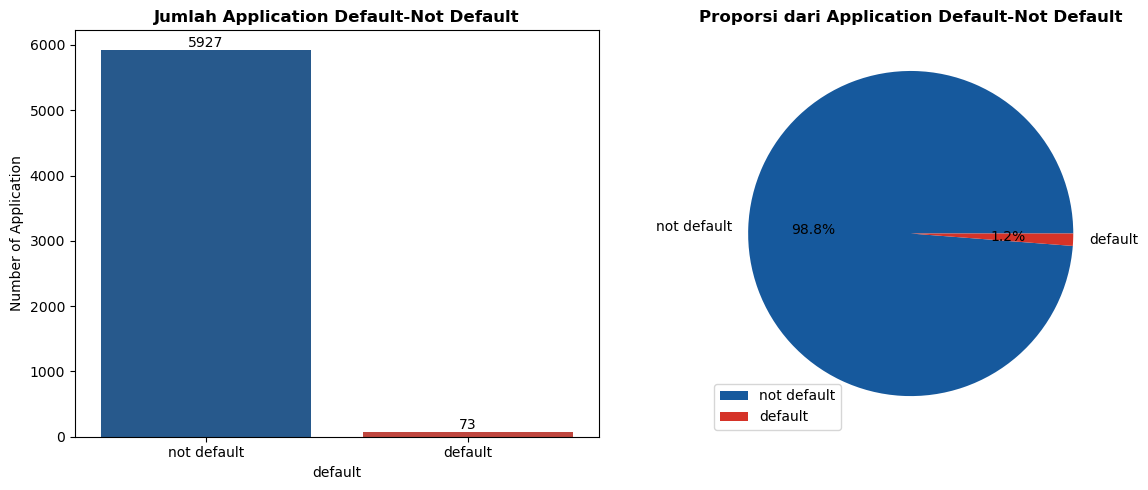

In [31]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title('Jumlah Application Default-Not Default', fontweight='bold')
cntplot = sns.countplot(x=df_clean['default'], hue=df_clean['default'], palette=['#16599d', '#d53328'], legend=False)
for p in cntplot.patches:
    if p.get_height() > 1:
        cntplot.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.xticks(ticks=[0,1], labels=['not default', 'default'])
plt.ylabel('Number of Application')

plt.subplot(1,2,2)
plt.title('Proporsi dari Application Default-Not Default', fontweight='bold')
plt.pie(x=df_clean['default'].value_counts(), labels=df_clean['default'].value_counts().reset_index()['default'].map({0:'not default', 1:'default'}), autopct='%.1f%%', colors=['#16599d', '#d53328'])
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

Dari seluruh pengajuan kredit, 1,2% pengajuan dinyatakan default. Hal ini mengimplikasikan adanya *imbalanced dataset*, sehingga diperlukan penggunaan *resampler* pada tahapan modelling

**Hubungan Umur, Pendapatan Bulanan, Nilai Pinjaman, dan Skor Kredit terhadap Default**

Visualisasi dilakukan menggunakan box-plot, karena jumlah data default yang sangat sedikit dati keseluruhan data, yang menyebabkan kurang terlihat jika visualisasi menggunakan histogram.

In [34]:
df_clean.columns

Index(['age', 'monthly_income', 'loan_amount', 'previous_defaults',
       'credit_score', 'default'],
      dtype='object')

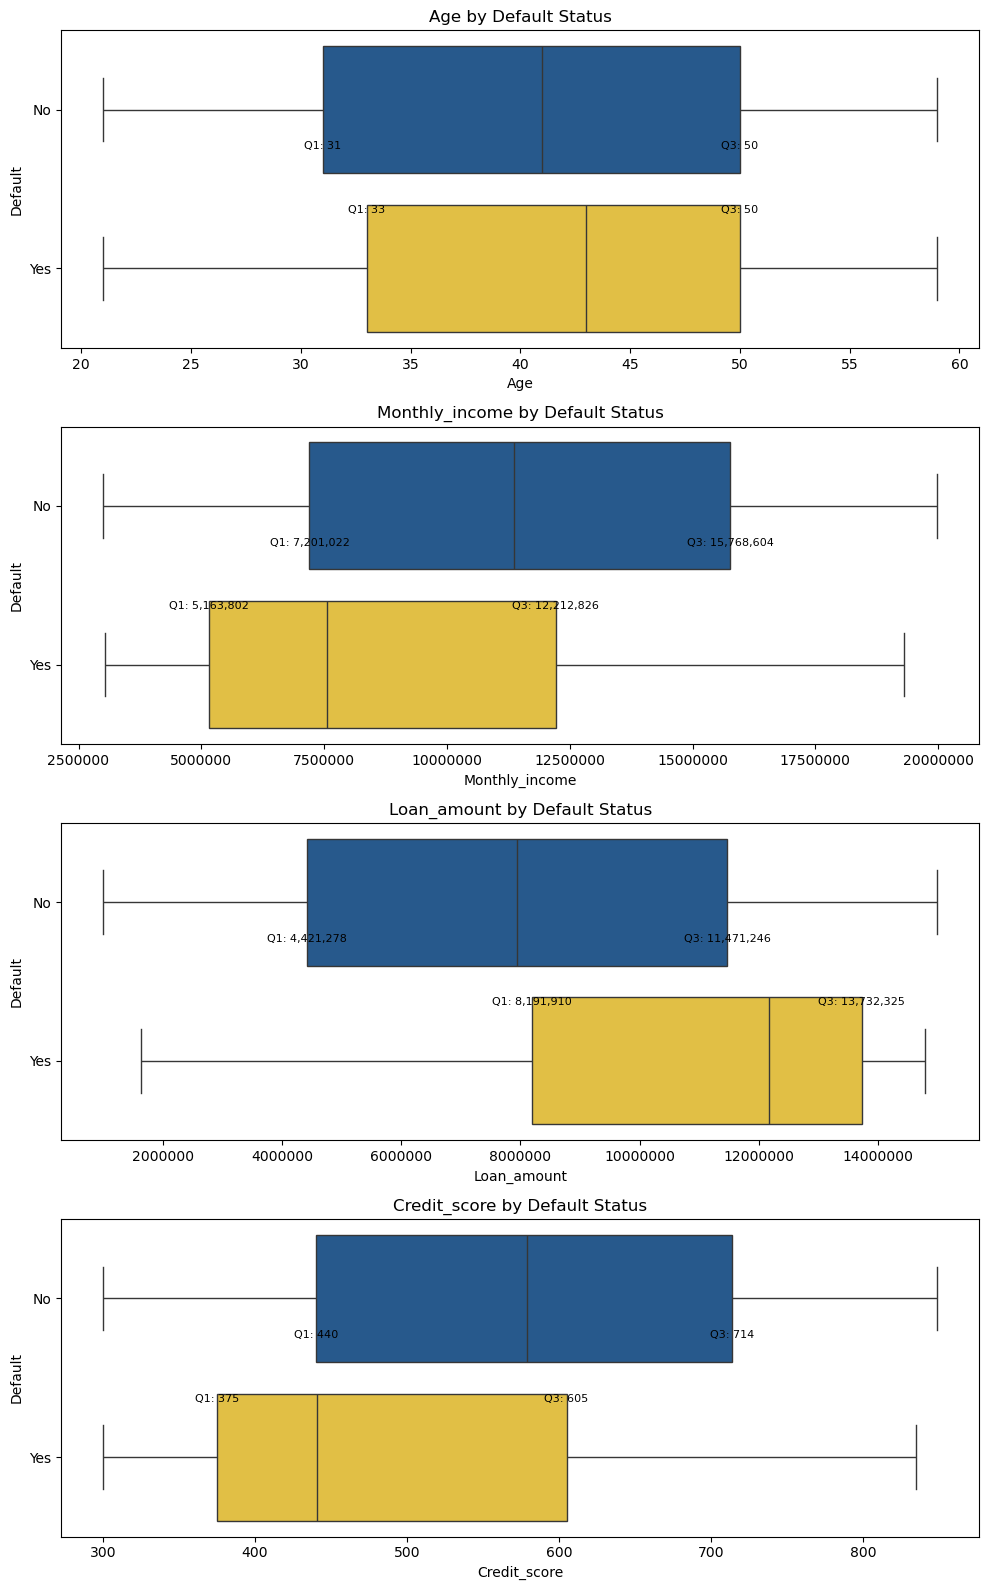

In [35]:
from matplotlib.ticker import ScalarFormatter

feature_cols = ['age', 'monthly_income', 'loan_amount', 'credit_score']

plt.figure(figsize=(10, 4 * len(feature_cols)))

for idx, col in enumerate(feature_cols):
    plt.subplot(len(feature_cols), 1, idx + 1)
    ax = sns.boxplot(data=df_clean, y='default', x=col, palette=['#16599d', '#fbcd2b'], orient='h')
    plt.title(f'{col.capitalize()} by Default Status')
    plt.ylabel('Default')
    plt.xlabel(col.capitalize())
    plt.yticks([0, 1], ['No', 'Yes'])

    # Nonaktifkan notasi ilmiah
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    plt.ticklabel_format(style='plain', axis='x')

    for y_val in [0, 1]:  
        subset = df_clean[df_clean['default'] == y_val][col]
        q1 = subset.quantile(0.25)
        q3 = subset.quantile(0.75)

        offset = 0.25 if y_val == 0 else -0.35

        # Anotasi Q1 dan Q3 dengan warna hitam
        plt.annotate(f'Q1: {q1:,.0f}', xy=(q1, y_val + offset), ha='center', fontsize=8, color='black')
        plt.annotate(f'Q3: {q3:,.0f}', xy=(q3, y_val + offset), ha='center', fontsize=8, color='black')

plt.tight_layout()
plt.show()



Berdasarkan Visualisasi Box Plot tersebut:
- Applicant yang default mayoritas memiliki umur diantara 33 Tahun - 50 tahun, lebih tinggi dari mayoritas umur non-default applicant.
- Non-default applicant umumnya memiliki pendapatan bulanan diantara IDR 7,2 Juta s.d. 16 Juta, lebih tinggi dari default applicant (IDR 5,1 Juta s.d. 12 Juta).
- Default application memiliki loan amount yang lebih tinggi dibandingkan non-default application, yakni mayoritas pinjaman bernilai sebesar IDR 8 Juta s.d. 14 Juta.
- Default application memiliki credit score yang lebih rendah dari non-default, dengan default application mayoritas memiliki skor 375 s.d. 605.
- Fitur loan amount dan credit score dapat menjadi fitur yang baik dalam pembuatan model

**Hubungan Jumlah Default Sebelumnya terhadap Default**

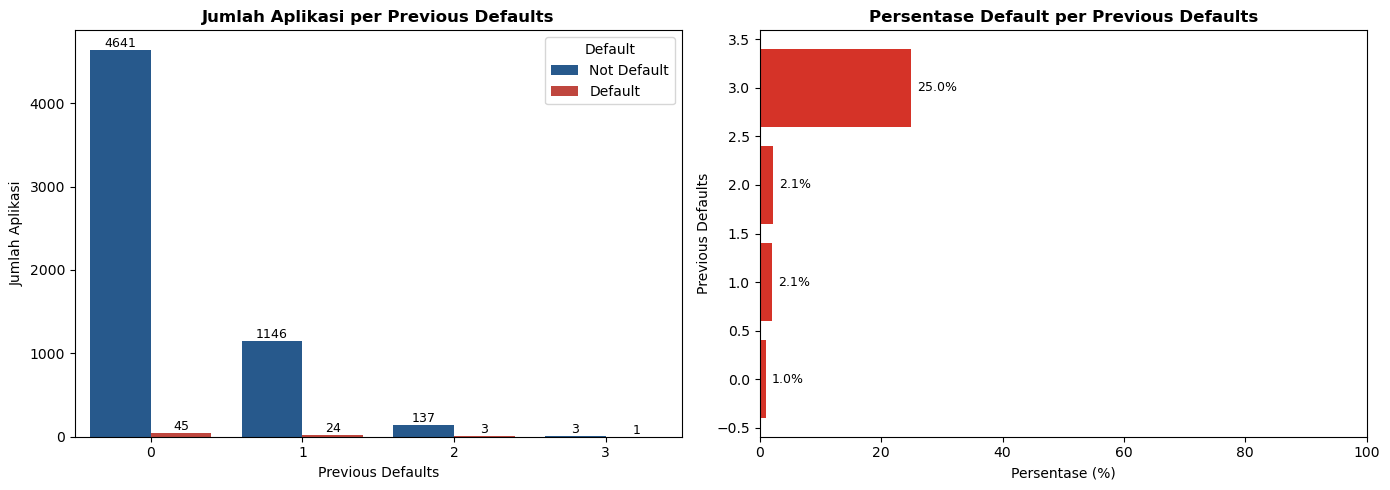

In [38]:
plt.figure(figsize=(14,5))

# Grafik kiri: jumlah aplikasi per previous_defaults
plt.subplot(1, 2, 1)
plt.title('Jumlah Aplikasi per Previous Defaults', fontweight='bold')
countplot = sns.countplot(data=df_clean, x='previous_defaults', hue='default', palette=['#16599d', '#d53328'])
plt.xlabel('Previous Defaults')
plt.ylabel('Jumlah Aplikasi')
plt.legend(title='Default', labels=['Not Default', 'Default'])

# Anotasi jumlah pada bar kiri
for p in countplot.patches:
    height = p.get_height()
    if height > 0:
        countplot.annotate(f'{int(height)}', 
                           (p.get_x() + p.get_width() / 2, height), 
                           ha='center', va='bottom', fontsize=9)

# Grafik kanan: persentase default per previous_defaults (horizontal bar)
plt.subplot(1, 2, 2)
plt.title('Persentase Default per Previous Defaults', fontweight='bold')

# Hitung proporsi default=1
default_rate = df_clean[df_clean['default'] == 1].groupby('previous_defaults').size() / df_clean.groupby('previous_defaults').size()
default_rate = default_rate.fillna(0)  # antisipasi NaN jika tidak ada kasus default

# Plot horizontal bar
bars = plt.barh(default_rate.index, default_rate.values * 100, color='#d53328')
plt.xlabel('Persentase (%)')
plt.ylabel('Previous Defaults')
plt.xlim(0, 100)

# Anotasi persentase pada bar kanan
for bar in bars:
    width = bar.get_width()
    if width > 0:
        plt.text(width + 1, bar.get_y() + bar.get_height() / 2,
                 f'{width:.1f}%', va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()

Visualisasi menunjukkan bahwa meningkatnya previous defaults, berhubungan dengan default, namun tidak cukup signifikan. Untuk previous defaults 3, memiliki persentase default sebesar 25%, namun hanya berdasarkan 4 aplikasi.

# MODELLING

Pemodelan dilakukan dengan menggunakan algoritma **Logistic Regression** dan **Gradient Boosting**, baik dalam bentuk baseline maupun setelah dilakukan hyperparameter tuning. Berdasarkan hasil eksplorasi data, dipilih penggunaan **Standard Scaler** atau **Min-Max Scaler**, mengingat sebagian besar fitur numerik terdistribusi normal, serta tidak adanya fitur kategorikal. Mengingat bahwa  label default bersifat **imbalanced** (hanya sekitar 1% yang termasuk dalam kategori default), maka diterapkan teknik **resampling** dalam proses pelatihan model. Teknik resampling yang digunakan meliputi **Random Over-Sampling**, **Random Under-Sampling**, serta **SMOTE (Synthetic Minority Over-sampling Technique)**.

In [42]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import (RandomOverSampler, SMOTE)
from imblearn.under_sampling import (RandomUnderSampler)
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score,roc_curve,precision_recall_curve, classification_report, confusion_matrix, PrecisionRecallDisplay, RocCurveDisplay, fbeta_score, make_scorer, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import RocCurveDisplay
from sklearn.impute import SimpleImputer
import time

In [43]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Evaluates the given model on both the training and test datasets, 
    displaying classification reports, confusion matrix heatmaps, 
    ROC curves with AUC, and prints ROC AUC scores.
    """
    # Predict train and test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # ROC AUC Score
    auc_train = roc_auc_score(y_train, y_train_prob)
    auc_test = roc_auc_score(y_test, y_test_prob)
    print(f"ROC AUC Score - Train: {auc_train:.4f}")
    print(f"ROC AUC Score - Test:  {auc_test:.4f}\n")

    # Recall Score
    recall_train = recall_score(y_train, y_train_pred)
    recall_test = recall_score(y_test, y_test_pred)
    print(f"Recall Score - Train: {recall_train:.4f}")
    print(f"Recall Score - Test:  {recall_test:.4f}\n")
    
    # Classification Report
    print("Classification Report - Train Data")
    print(classification_report(y_train, y_train_pred))
    
    print("\nClassification Report - Test Data")
    print(classification_report(y_test, y_test_pred))

    # Confusion Matrices
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
        
    # Heatmap for Confusion Matrices
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'], ax=ax[0])
    ax[0].set_title('Confusion Matrix - Train Data')
    
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'], ax=ax[1])
    ax[1].set_title('Confusion Matrix - Test Data')

    plt.tight_layout()
    plt.show()

## CEK MULTICOLLINEARITY

Sebelum dilakukan modelling, perlu dilakukan pengecekan ada/tidaknya multicollinearity pada fitur. Selain itu, label akan dipisahkan dari fitur agar tidak terjadi *data leakage*. Karena data terdistribusi normal, metode pearson digunakan untuk pengecekan korelasi antar fitur.

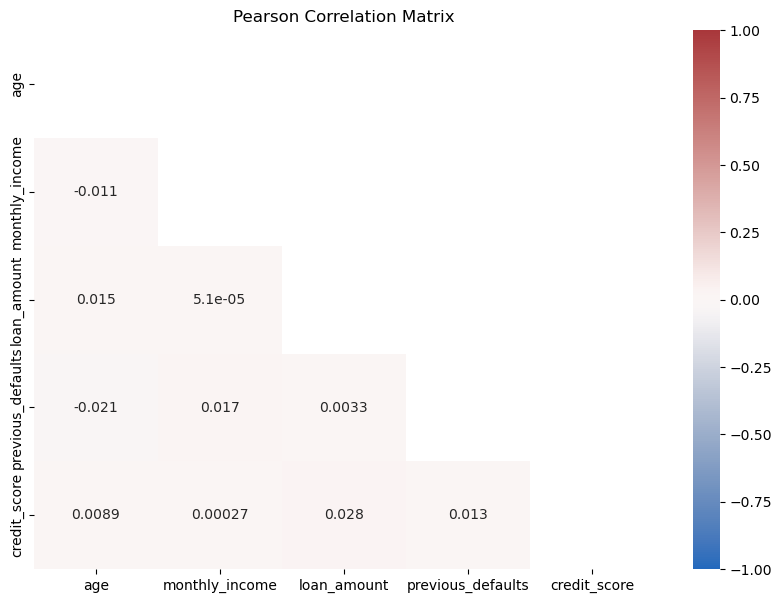

In [46]:
X = df_clean.drop(columns='default').select_dtypes(include='number')
corr = X.corr(method='pearson')

plt.figure(figsize=(10, 7))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='vlag', mask=np.triu(np.ones_like(corr, dtype=bool)))
plt.title('Pearson Correlation Matrix')
plt.show()

Tidak ada multicollinearity, sehingga fitur yang tersedia dapat digunakan untuk proses modelling.

## Train-Test Split

In [49]:
train, test = train_test_split(df_clean, stratify=df_clean['default'], random_state=42, test_size=0.2)
display(train.shape, test.shape)

(4800, 6)

(1200, 6)

## PREPROCESSING

Seperti yang sudah disebutkan, label akan dipisahkan dari data modelling, agar tidak terjadi adanya *data leakage*. Scaler yang digunakan adalah *Standard Scaler*, karena fitur terdistribusi normal.

In [52]:
X_train = train.drop("default",axis=1)
y_train = train["default"]

X_test = test.drop("default",axis=1)
y_test = test["default"]

In [53]:
# Define features
features = X_train.columns.tolist()
features

['age', 'monthly_income', 'loan_amount', 'previous_defaults', 'credit_score']

In [54]:
# Define the transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])   

# Define the preprocessor with the addition of BinaryEncoder for county column
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, features)
], remainder='passthrough')

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['age', 'monthly_income', 'loan_amount',
                                  'previous_defaults', 'credit_score'])])

## LOGISTIC REGRESSION

Pertama metode Logistic Regression akan digunakan untuk pembuatan model. Adapun proses modelling bertujuan untuk mendapatkan model terbaik dengan **ROC-AUC Score** yang tinggi, diikuti dengan **Recall** label 1, **fitting time** yang rendah, serta model yang stabil.

### BASELINE LOGREG

In [58]:
pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("sampler", SMOTE(random_state=42)),
    ('classifier', LogisticRegression())
])

param_grid = [
    {
        'sampler': [SMOTE(random_state=42), RandomOverSampler(random_state=42), RandomUnderSampler(random_state=42)],
        'classifier': [LogisticRegression(random_state=42)]
    },
]

# Define scoring as a dictionary
scoring = {
    'roc_auc': 'roc_auc',
    'recall': 'recall'
}

gscv = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring=scoring,refit = 'roc_auc', error_score="raise")

start_time = time.time()

gscv.fit(X_train, y_train)


end_time = time.time()

fitting_time = end_time - start_time
print(f"Fitting time: {fitting_time:.2f} seconds")

Fitting time: 7.27 seconds


In [59]:
pd.DataFrame(gscv.cv_results_).sort_values(by='mean_test_roc_auc', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_sampler,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
2,0.018277,0.003255,0.017478,0.004608,LogisticRegression(random_state=42),RandomUnderSampler(random_state=42),{'classifier': LogisticRegression(random_state...,0.760705,0.869336,0.751582,0.772152,0.835795,0.797914,0.046327,1,0.818182,1.000000,0.583333,0.666667,0.833333,0.780303,0.144377,1
1,0.028837,0.003941,0.017997,0.002228,LogisticRegression(random_state=42),RandomOverSampler(random_state=42),{'classifier': LogisticRegression(random_state...,0.728614,0.858416,0.719673,0.765120,0.853991,0.785163,0.059986,2,0.636364,1.000000,0.583333,0.666667,0.916667,0.760606,0.165741,2
0,0.038303,0.012347,0.019701,0.002974,LogisticRegression(random_state=42),SMOTE(random_state=42),{'classifier': LogisticRegression(random_state...,0.729093,0.853243,0.716772,0.763010,0.854255,0.783274,0.059502,3,0.545455,0.909091,0.583333,0.666667,0.916667,0.724242,0.158954,3


In [60]:
gscv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'monthly_income',
                                                   'loan_amount',
                                                   'previous_defaults',
                                                   'credit_score'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('classifier', LogisticRegression(random_state=42))])

ROC AUC Score - Train: 0.7994
ROC AUC Score - Test:  0.7721

Recall Score - Train: 0.7241
Recall Score - Test:  0.6000

Classification Report - Train Data
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      4742
           1       0.03      0.72      0.06        58

    accuracy                           0.71      4800
   macro avg       0.51      0.72      0.44      4800
weighted avg       0.98      0.71      0.82      4800


Classification Report - Test Data
              precision    recall  f1-score   support

           0       0.99      0.71      0.83      1185
           1       0.03      0.60      0.05        15

    accuracy                           0.71      1200
   macro avg       0.51      0.66      0.44      1200
weighted avg       0.98      0.71      0.82      1200



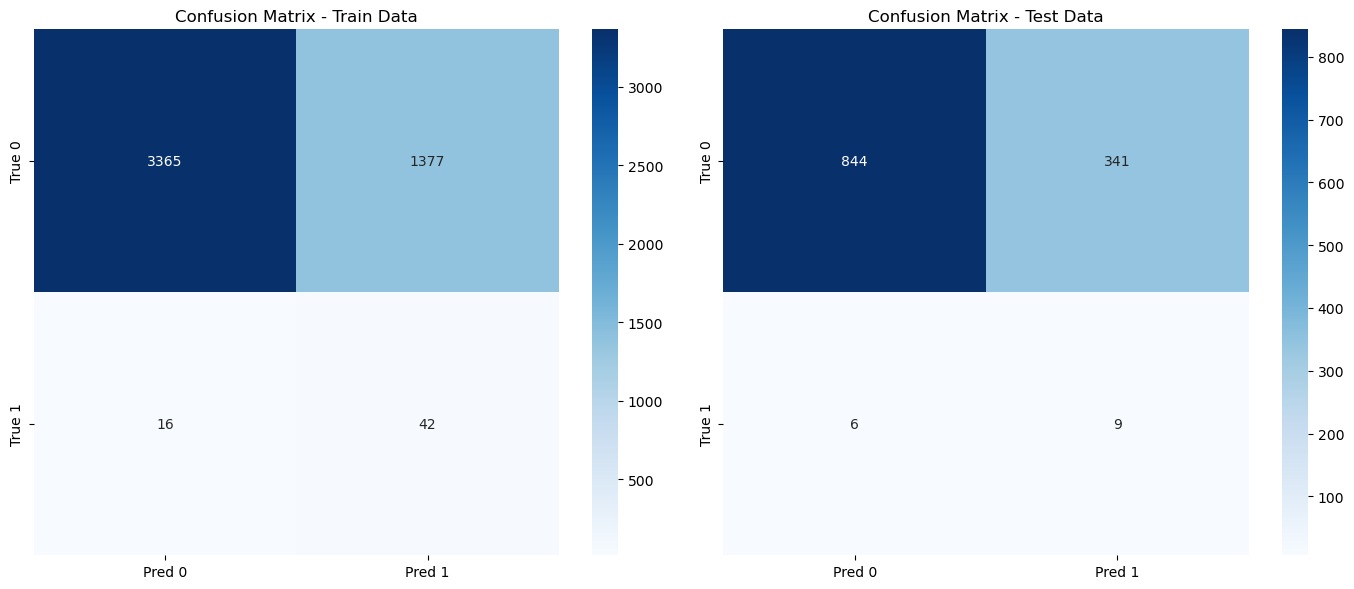

In [61]:
evaluate_model(gscv.best_estimator_, X_train, X_test, y_train, y_test)

Random Under-Sampling merupakan metode yang paling tepat digunakan untuk baseline logreg. Hasil menunjukkan ROC-AUC score yang cukup baik dan tidak overfitted (diatas 0,7 untuk train dan tes), namun dengan recall 1 yang masih overfitted. Classification report menunjukkan bahwa pada data tes, model tepat memprediksi 9 aplikasi yang default, dari total 15 aplikasi yang default pada data tes.

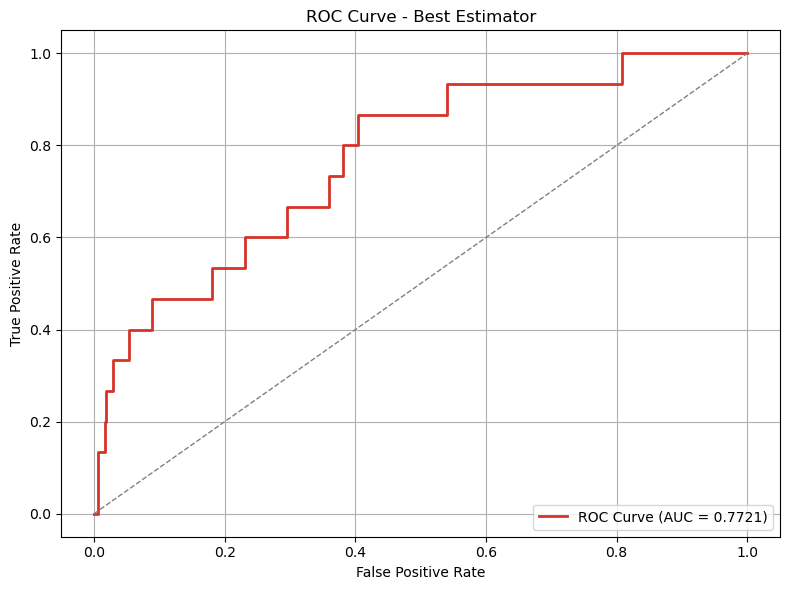

In [63]:
# Prediksi probabilitas positive class (label = 1)
y_proba = gscv.best_estimator_.predict_proba(X_test)[:, 1]

# Hitung ROC curve dan ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Visualisasi ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#d53328', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best Estimator')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### HYPERPARAMETER TUNING - LOGREG

Digunakan parameter regularisasi untuk proses tuning logreg,

In [66]:
# Define pipeline
pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("sampler", SMOTE(random_state=42)),  # default placeholder
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))  # default placeholder
])

# Define param grid for Logistic Regression tuning
param_grid = {
    'sampler': [
        SMOTE(random_state=42), 
        RandomOverSampler(random_state=42), 
        RandomUnderSampler(random_state=42)
    ],
    'classifier': [LogisticRegression(max_iter=1000, random_state=42)],
    'classifier__penalty': ['l2', None],  # 'l2' for regularized, 'none' for unregularized
    'classifier__C': [0.01, 0.1, 1, 10],    # lower = stronger regularization
    'classifier__solver': ['lbfgs']         # 'lbfgs' supports 'l2' and 'none'
}

# Define scoring
scoring = {
    'roc_auc': 'roc_auc',
    'recall': 'recall'
}

# GridSearchCV setup
gscv = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring=scoring,
    refit='roc_auc',
    error_score="raise"
)

# Fit and measure time
start_time = time.time()
gscv.fit(X_train, y_train)
fitting_time = time.time() - start_time
print(f"Fitting time: {fitting_time:.2f} seconds")


Fitting time: 0.52 seconds


In [67]:
pd.DataFrame(gscv.cv_results_).sort_values(by='mean_test_roc_auc', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__penalty,param_classifier__solver,param_sampler,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
8,0.018590,0.002551,0.025801,0.010283,"LogisticRegression(max_iter=1000, random_state...",0.1,l2,lbfgs,RandomUnderSampler(random_state=42),{'classifier': LogisticRegression(max_iter=100...,0.753425,0.871731,0.780503,0.769866,0.834300,0.801965,0.044181,1,0.727273,1.000000,0.583333,0.666667,0.833333,0.762121,0.144186,8
2,0.014500,0.003649,0.011494,0.003694,"LogisticRegression(max_iter=1000, random_state...",0.01,l2,lbfgs,RandomUnderSampler(random_state=42),{'classifier': LogisticRegression(max_iter=100...,0.740971,0.872497,0.801600,0.764680,0.820851,0.800120,0.045662,2,0.727273,1.000000,0.750000,0.666667,0.750000,0.778788,0.114732,7
14,0.017644,0.003610,0.014574,0.001038,"LogisticRegression(max_iter=1000, random_state...",1,l2,lbfgs,RandomUnderSampler(random_state=42),{'classifier': LogisticRegression(max_iter=100...,0.760705,0.869336,0.751582,0.772152,0.835795,0.797914,0.046327,3,0.818182,1.000000,0.583333,0.666667,0.833333,0.780303,0.144377,1
23,0.013328,0.002447,0.011860,0.003539,"LogisticRegression(max_iter=1000, random_state...",10,None,lbfgs,RandomUnderSampler(random_state=42),{'classifier': LogisticRegression(max_iter=100...,0.762525,0.867803,0.747275,0.772855,0.835531,0.797198,0.046350,4,0.818182,1.000000,0.583333,0.666667,0.833333,0.780303,0.144377,1
5,0.028854,0.014161,0.021781,0.005642,"LogisticRegression(max_iter=1000, random_state...",0.01,None,lbfgs,RandomUnderSampler(random_state=42),{'classifier': LogisticRegression(max_iter=100...,0.762525,0.867803,0.747275,0.772855,0.835531,0.797198,0.046350,4,0.818182,1.000000,0.583333,0.666667,0.833333,0.780303,0.144377,1
11,0.015925,0.001358,0.019673,0.007428,"LogisticRegression(max_iter=1000, random_state...",0.1,None,lbfgs,RandomUnderSampler(random_state=42),{'classifier': LogisticRegression(max_iter=100...,0.762525,0.867803,0.747275,0.772855,0.835531,0.797198,0.046350,4,0.818182,1.000000,0.583333,0.666667,0.833333,0.780303,0.144377,1
17,0.020539,0.009325,0.013877,0.000853,"LogisticRegression(max_iter=1000, random_state...",1,None,lbfgs,RandomUnderSampler(random_state=42),{'classifier': LogisticRegression(max_iter=100...,0.762525,0.867803,0.747275,0.772855,0.835531,0.797198,0.046350,4,0.818182,1.000000,0.583333,0.666667,0.833333,0.780303,0.144377,1
20,0.014977,0.001005,0.014495,0.001107,"LogisticRegression(max_iter=1000, random_state...",10,l2,lbfgs,RandomUnderSampler(random_state=42),{'classifier': LogisticRegression(max_iter=100...,0.762238,0.867995,0.747363,0.772591,0.835619,0.797161,0.046475,8,0.818182,1.000000,0.583333,0.666667,0.833333,0.780303,0.144377,1
1,0.020939,0.001206,0.015821,0.002202,"LogisticRegression(max_iter=1000, random_state...",0.01,l2,lbfgs,RandomOverSampler(random_state=42),{'classifier': LogisticRegression(max_iter=100...,0.727369,0.859948,0.723365,0.764768,0.854694,0.786029,0.059998,9,0.636364,1.000000,0.583333,0.666667,0.916667,0.760606,0.165741,9
7,0.029700,0.013511,0.017720,0.002041,"LogisticRegression(max_iter=1000, random_state...",0.1,l2,lbfgs,RandomOverSampler(random_state=42),{'classifier': LogisticRegression(max_iter=100...,0.728805,0.858416,0.719673,0.765295,0.854430,0.785324,0.060039,10,0.636364,1.000000,0.583333,0.666667,0.916667,0.760606,0.165741,9


In [68]:
gscv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'monthly_income',
                                                   'loan_amount',
                                                   'previous_defaults',
                                                   'credit_score'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000, random_state=42))])

ROC AUC Score - Train: 0.8016
ROC AUC Score - Test:  0.7752

Recall Score - Train: 0.7069
Recall Score - Test:  0.6000

Classification Report - Train Data
              precision    recall  f1-score   support

           0       0.99      0.71      0.83      4742
           1       0.03      0.71      0.06        58

    accuracy                           0.71      4800
   macro avg       0.51      0.71      0.44      4800
weighted avg       0.98      0.71      0.82      4800


Classification Report - Test Data
              precision    recall  f1-score   support

           0       0.99      0.72      0.84      1185
           1       0.03      0.60      0.05        15

    accuracy                           0.72      1200
   macro avg       0.51      0.66      0.44      1200
weighted avg       0.98      0.72      0.83      1200



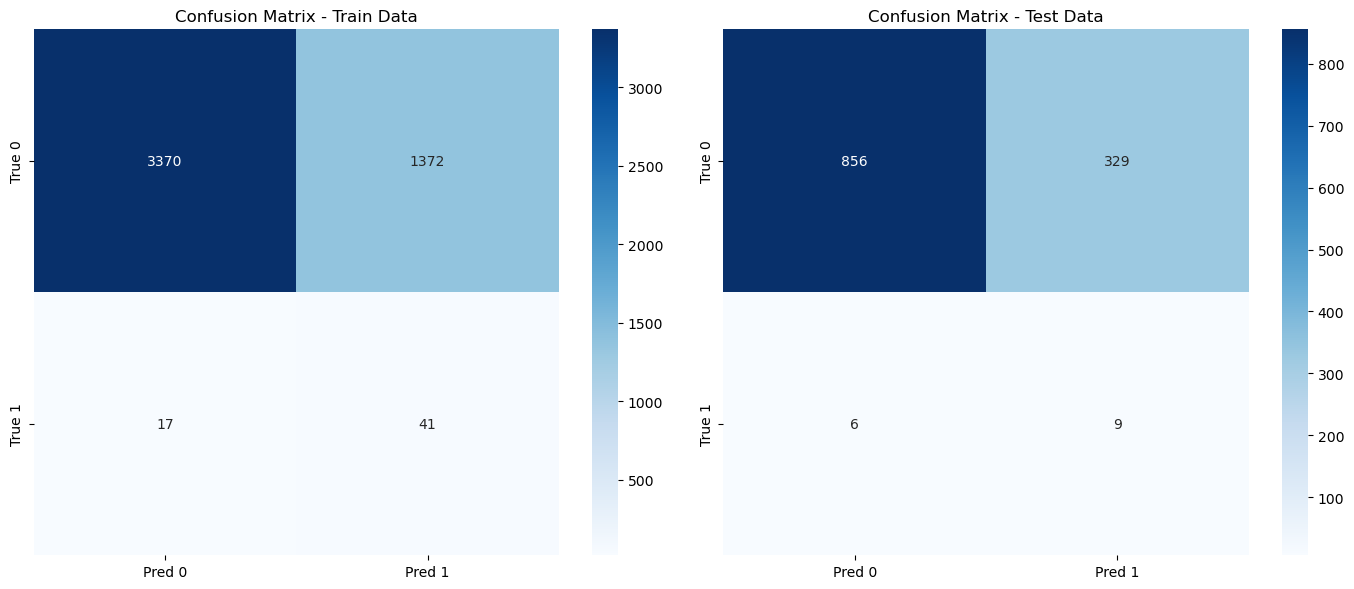

In [69]:
evaluate_model(gscv.best_estimator_, X_train, X_test, y_train, y_test)

Random Under-Sampling merupakan metode yang paling tepat digunakan untuk tuned-logreg. Hasil menunjukkan ROC-AUC score yang cukup baik dan tidak overfitted (diatas 0,7 untuk train dan tes), namun dengan recall 1 yang masih overfitted. Karena tidak terjadi perubahan yang signifikan, baseline logreg lebih dipilih jika dibandingkan tuned-logreg. Classification report menunjukkan bahwa pada data tes, model mampu memprediksi dengan tepat 9 default application, dari 15 default application yang ada pada data tes.

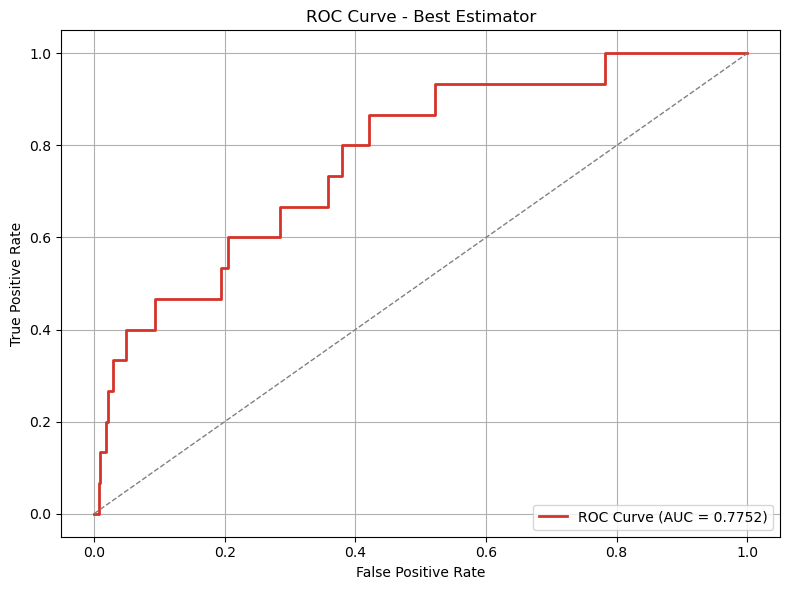

In [71]:
# Prediksi probabilitas positive class (label = 1)
y_proba = gscv.best_estimator_.predict_proba(X_test)[:, 1]

# Hitung ROC curve dan ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Visualisasi ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#d53328', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best Estimator')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## GRADIENT BOOSTING

Berikutnya merupakan modelling dengan menggunakan metode *Gradient Boosting*. Baseline dan hasil tuning akan dibanding untuk menentukan model *Gradient Boosting* terbaik, dan dibandingkan dengan model logreg yang telah terpilih.

### Baseline GradientBoosting

In [75]:
pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("sampler", SMOTE(random_state=42)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

param_grid = [
    {
        'sampler': [SMOTE(random_state=42), RandomOverSampler(random_state=42), RandomUnderSampler(random_state=42)],
        'classifier': [GradientBoostingClassifier(random_state=42)]
    },
]

# Define scoring as a dictionary
scoring = {
    'roc_auc': 'roc_auc',
    'recall': 'recall'
}

gscv = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring=scoring,refit = 'roc_auc', error_score="raise")

start_time = time.time()


gscv.fit(X_train, y_train)


end_time = time.time()

fitting_time = end_time - start_time
print(f"Fitting time: {fitting_time:.2f} seconds")

Fitting time: 2.34 seconds


In [76]:
pd.DataFrame(gscv.cv_results_).sort_values(by='mean_test_roc_auc', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_sampler,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
1,0.940606,0.031342,0.013169,0.001207,GradientBoostingClassifier(random_state=42),RandomOverSampler(random_state=42),{'classifier': GradientBoostingClassifier(rand...,0.714915,0.875084,0.730617,0.733562,0.738660,0.758568,0.058795,1,0.181818,0.545455,0.333333,0.416667,0.166667,0.328788,0.143228,3
0,1.432212,0.040160,0.010849,0.000260,GradientBoostingClassifier(random_state=42),SMOTE(random_state=42),{'classifier': GradientBoostingClassifier(rand...,0.735511,0.827474,0.697609,0.669743,0.792106,0.744489,0.058342,2,0.454545,0.545455,0.416667,0.333333,0.333333,0.416667,0.079887,2
2,0.172677,0.014024,0.025142,0.012735,GradientBoostingClassifier(random_state=42),RandomUnderSampler(random_state=42),{'classifier': GradientBoostingClassifier(rand...,0.717118,0.825175,0.641702,0.713300,0.689522,0.717363,0.060232,3,0.636364,0.727273,0.500000,0.583333,0.666667,0.622727,0.077020,1


In [77]:
gscv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'monthly_income',
                                                   'loan_amount',
                                                   'previous_defaults',
                                                   'credit_score'])])),
                ('sampler', RandomOverSampler(random_state=42)),
                ('classifier', GradientBoostingClassifier(random_state=42))])

ROC AUC Score - Train: 0.9908
ROC AUC Score - Test:  0.5476

Recall Score - Train: 1.0000
Recall Score - Test:  0.1333

Classification Report - Train Data
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      4742
           1       0.13      1.00      0.23        58

    accuracy                           0.92      4800
   macro avg       0.56      0.96      0.59      4800
weighted avg       0.99      0.92      0.95      4800


Classification Report - Test Data
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1185
           1       0.02      0.13      0.04        15

    accuracy                           0.91      1200
   macro avg       0.50      0.53      0.50      1200
weighted avg       0.98      0.91      0.94      1200



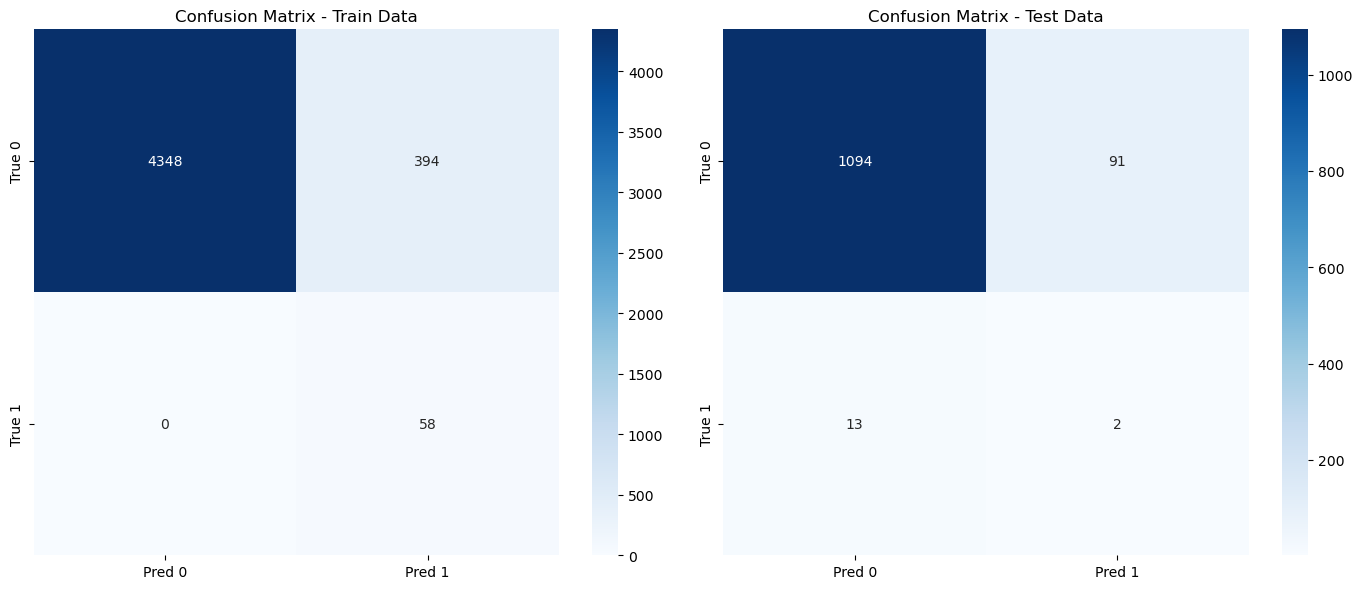

In [78]:
evaluate_model(gscv.best_estimator_, X_train, X_test, y_train, y_test)

Hasil tersebut menunjukkan bahwa baseline *GradientBoosting* mengalami overfitted, dengan adanya perbedaan cukup signfikan antara skor train dengan tes, sehingga performa baseline model ini tidak baik dan perlu di-tuning.

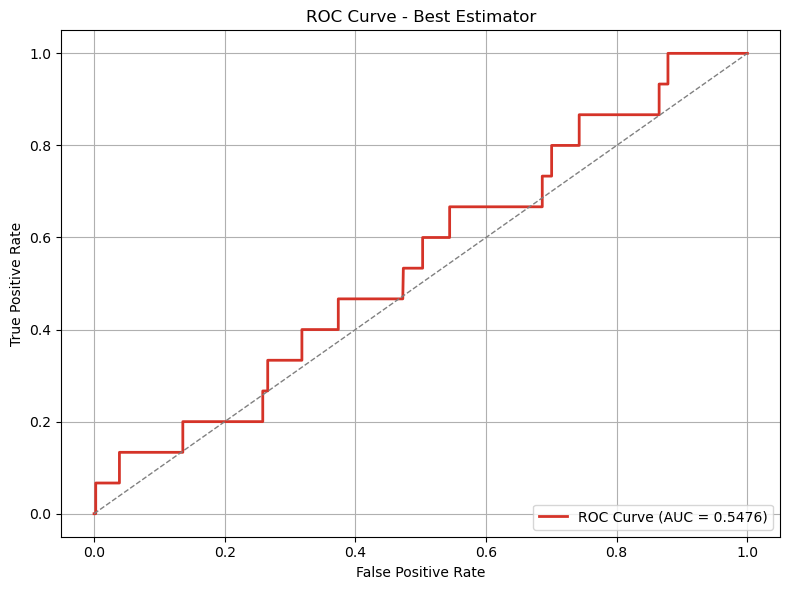

In [80]:
# Prediksi probabilitas positive class (label = 1)
y_proba = gscv.best_estimator_.predict_proba(X_test)[:, 1]

# Hitung ROC curve dan ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Visualisasi ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#d53328', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best Estimator')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

### Hyperparameter Tuning - GradientBoosting

In [82]:
# Updated pipeline with feature selection step
pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),  # include scaler if needed in your preprocessor
    ("sampler", SMOTE(random_state=42)),  # placeholder
    ("classifier", GradientBoostingClassifier(random_state=42))  # placeholder
])

# Define param grid (add threshold tuning for feature selection optionally)
param_grid = {
    'sampler': [
        SMOTE(random_state=42),
        RandomOverSampler(random_state=42),
        RandomUnderSampler(random_state=42)
    ],
    'classifier': [GradientBoostingClassifier(random_state=42)],
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5]
}

# Scoring metrics
scoring = {
    'roc_auc': 'roc_auc',
    'recall': 'recall'
}

# GridSearchCV setup
gscv = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring=scoring,
    refit='roc_auc',
    error_score="raise"
)

# Fit
start_time = time.time()
gscv.fit(X_train, y_train)
fitting_time = time.time() - start_time
print(f"Fitting time: {fitting_time:.2f} seconds")


Fitting time: 22.37 seconds


In [83]:
pd.DataFrame(gscv.cv_results_).sort_values(by='mean_test_roc_auc', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,param_sampler,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
3,3.030125,0.080706,0.018601,0.001216,GradientBoostingClassifier(random_state=42),0.01,3,200,SMOTE(random_state=42),{'classifier': GradientBoostingClassifier(rand...,0.732015,0.893189,0.733430,0.725870,0.831531,0.783207,0.067553,1,0.545455,0.909091,0.583333,0.500000,0.833333,0.674242,0.164727,3
4,1.908564,0.055348,0.019211,0.001306,GradientBoostingClassifier(random_state=42),0.01,3,200,RandomOverSampler(random_state=42),{'classifier': GradientBoostingClassifier(rand...,0.702558,0.920395,0.757867,0.735935,0.768152,0.776981,0.075146,2,0.545455,0.909091,0.666667,0.583333,0.416667,0.624242,0.163650,11
6,2.534534,0.033366,0.018826,0.003178,GradientBoostingClassifier(random_state=42),0.01,5,100,SMOTE(random_state=42),{'classifier': GradientBoostingClassifier(rand...,0.711802,0.906073,0.708993,0.673479,0.844146,0.768899,0.089925,3,0.545455,0.909091,0.666667,0.416667,0.750000,0.657576,0.168815,5
0,1.647358,0.012716,0.016407,0.001496,GradientBoostingClassifier(random_state=42),0.01,3,100,SMOTE(random_state=42),{'classifier': GradientBoostingClassifier(rand...,0.702366,0.889645,0.732463,0.711498,0.804677,0.768130,0.070577,4,0.636364,0.818182,0.666667,0.583333,0.833333,0.707576,0.100229,2
9,5.054550,0.138711,0.023750,0.000586,GradientBoostingClassifier(random_state=42),0.01,5,200,SMOTE(random_state=42),{'classifier': GradientBoostingClassifier(rand...,0.700067,0.876521,0.730573,0.702532,0.822169,0.766372,0.070710,5,0.363636,0.545455,0.583333,0.500000,0.500000,0.498485,0.074289,15
13,0.951617,0.011764,0.019030,0.004303,GradientBoostingClassifier(random_state=42),0.1,3,100,RandomOverSampler(random_state=42),{'classifier': GradientBoostingClassifier(rand...,0.714915,0.875084,0.730617,0.733562,0.738660,0.758568,0.058795,6,0.181818,0.545455,0.333333,0.416667,0.166667,0.328788,0.143228,19
1,1.019846,0.037149,0.015083,0.001332,GradientBoostingClassifier(random_state=42),0.01,3,100,RandomOverSampler(random_state=42),{'classifier': GradientBoostingClassifier(rand...,0.673771,0.902577,0.755626,0.722090,0.715937,0.754000,0.078716,7,0.454545,0.909091,0.750000,0.583333,0.500000,0.639394,0.168352,8
2,0.183102,0.015050,0.019380,0.004461,GradientBoostingClassifier(random_state=42),0.01,3,100,RandomUnderSampler(random_state=42),{'classifier': GradientBoostingClassifier(rand...,0.728279,0.852907,0.702004,0.779052,0.706707,0.753790,0.056589,8,0.545455,0.909091,0.750000,0.666667,0.750000,0.724242,0.118976,1
10,3.108720,0.081413,0.022802,0.002157,GradientBoostingClassifier(random_state=42),0.01,5,200,RandomOverSampler(random_state=42),{'classifier': GradientBoostingClassifier(rand...,0.705000,0.910719,0.751187,0.675325,0.696554,0.747757,0.085164,9,0.454545,0.545455,0.583333,0.250000,0.166667,0.400000,0.164127,17
12,1.586339,0.059142,0.015702,0.001015,GradientBoostingClassifier(random_state=42),0.1,3,100,SMOTE(random_state=42),{'classifier': GradientBoostingClassifier(rand...,0.735511,0.827474,0.697609,0.669743,0.792106,0.744489,0.058342,10,0.454545,0.545455,0.416667,0.333333,0.333333,0.416667,0.079887,16


In [84]:
gscv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'monthly_income',
                                                   'loan_amount',
                                                   'previous_defaults',
                                                   'credit_score'])])),
                ('sampler', SMOTE(random_state=42)),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.01,
                                            n_estimators=200,
                                            random_state=42))])

ROC AUC Score - Train: 0.8954
ROC AUC Score - Test:  0.6844

Recall Score - Train: 0.8621
Recall Score - Test:  0.3333

Classification Report - Train Data
              precision    recall  f1-score   support

           0       1.00      0.80      0.89      4742
           1       0.05      0.86      0.09        58

    accuracy                           0.80      4800
   macro avg       0.52      0.83      0.49      4800
weighted avg       0.99      0.80      0.88      4800


Classification Report - Test Data
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      1185
           1       0.02      0.33      0.04        15

    accuracy                           0.79      1200
   macro avg       0.50      0.56      0.46      1200
weighted avg       0.98      0.79      0.87      1200



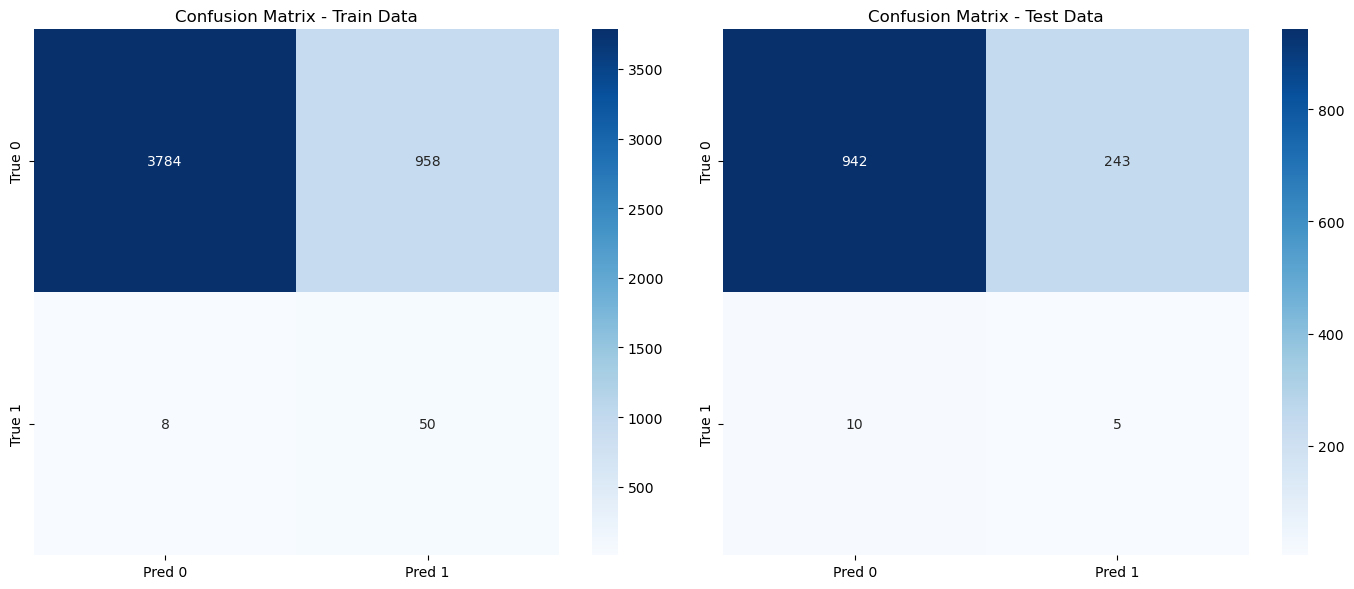

In [85]:
evaluate_model(gscv.best_estimator_, X_train, X_test, y_train, y_test)

Hasil tuning menunjukkan bahwa model masih overfit dan performanya tidak lebih baik dari model logreg yang telah terpilih

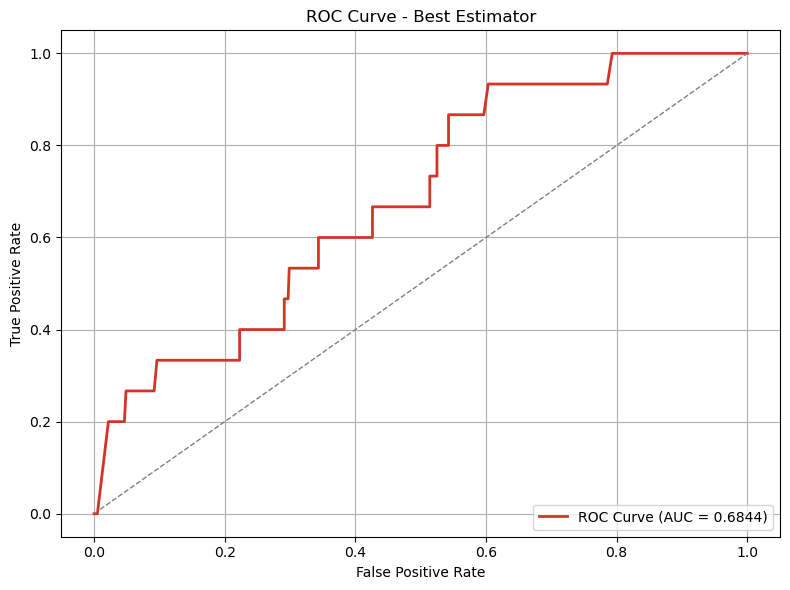

In [87]:
# Prediksi probabilitas positive class (label = 1)
y_proba = gscv.best_estimator_.predict_proba(X_test)[:, 1]

# Hitung ROC curve dan ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Visualisasi ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#d53328', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best Estimator')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## PEMILIHAN MODEL

Berdasarkan hasil modelling tersebut, baseline logistic regression +  Random Undersampling dipilih, karena menghasilkan auc score paling tinggi dibandingkan model yang lain, diatas 0,7 sesuai ketentuan, serta model yang stabil (perbedaan train vs test hanya sedikit).

**Model Terpilih**

In [91]:
pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("sampler", SMOTE(random_state=42)),
    ('classifier', LogisticRegression())
])

param_grid = [
    {
        'sampler': [SMOTE(random_state=42), RandomOverSampler(random_state=42), RandomUnderSampler(random_state=42)],
        'classifier': [LogisticRegression(random_state=42)]
    },
]

# Define scoring as a dictionary
scoring = {
    'roc_auc': 'roc_auc',
    'recall': 'recall'
}

gscv = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring=scoring,refit = 'roc_auc', error_score="raise")

start_time = time.time()


gscv.fit(X_train, y_train)


end_time = time.time()

fitting_time = end_time - start_time
print(f"Fitting time: {fitting_time:.2f} seconds")

Fitting time: 0.09 seconds


In [92]:
pd.DataFrame(gscv.cv_results_).sort_values(by='mean_test_roc_auc', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_sampler,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
2,0.013228,0.002647,0.010155,0.002020,LogisticRegression(random_state=42),RandomUnderSampler(random_state=42),{'classifier': LogisticRegression(random_state...,0.760705,0.869336,0.751582,0.772152,0.835795,0.797914,0.046327,1,0.818182,1.000000,0.583333,0.666667,0.833333,0.780303,0.144377,1
1,0.019009,0.001184,0.012519,0.000865,LogisticRegression(random_state=42),RandomOverSampler(random_state=42),{'classifier': LogisticRegression(random_state...,0.728614,0.858416,0.719673,0.765120,0.853991,0.785163,0.059986,2,0.636364,1.000000,0.583333,0.666667,0.916667,0.760606,0.165741,2
0,0.017775,0.001164,0.013941,0.000513,LogisticRegression(random_state=42),SMOTE(random_state=42),{'classifier': LogisticRegression(random_state...,0.729093,0.853243,0.716772,0.763010,0.854255,0.783274,0.059502,3,0.545455,0.909091,0.583333,0.666667,0.916667,0.724242,0.158954,3


In [93]:
gscv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'monthly_income',
                                                   'loan_amount',
                                                   'previous_defaults',
                                                   'credit_score'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('classifier', LogisticRegression(random_state=42))])

ROC AUC Score - Train: 0.7994
ROC AUC Score - Test:  0.7721

Recall Score - Train: 0.7241
Recall Score - Test:  0.6000

Classification Report - Train Data
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      4742
           1       0.03      0.72      0.06        58

    accuracy                           0.71      4800
   macro avg       0.51      0.72      0.44      4800
weighted avg       0.98      0.71      0.82      4800


Classification Report - Test Data
              precision    recall  f1-score   support

           0       0.99      0.71      0.83      1185
           1       0.03      0.60      0.05        15

    accuracy                           0.71      1200
   macro avg       0.51      0.66      0.44      1200
weighted avg       0.98      0.71      0.82      1200



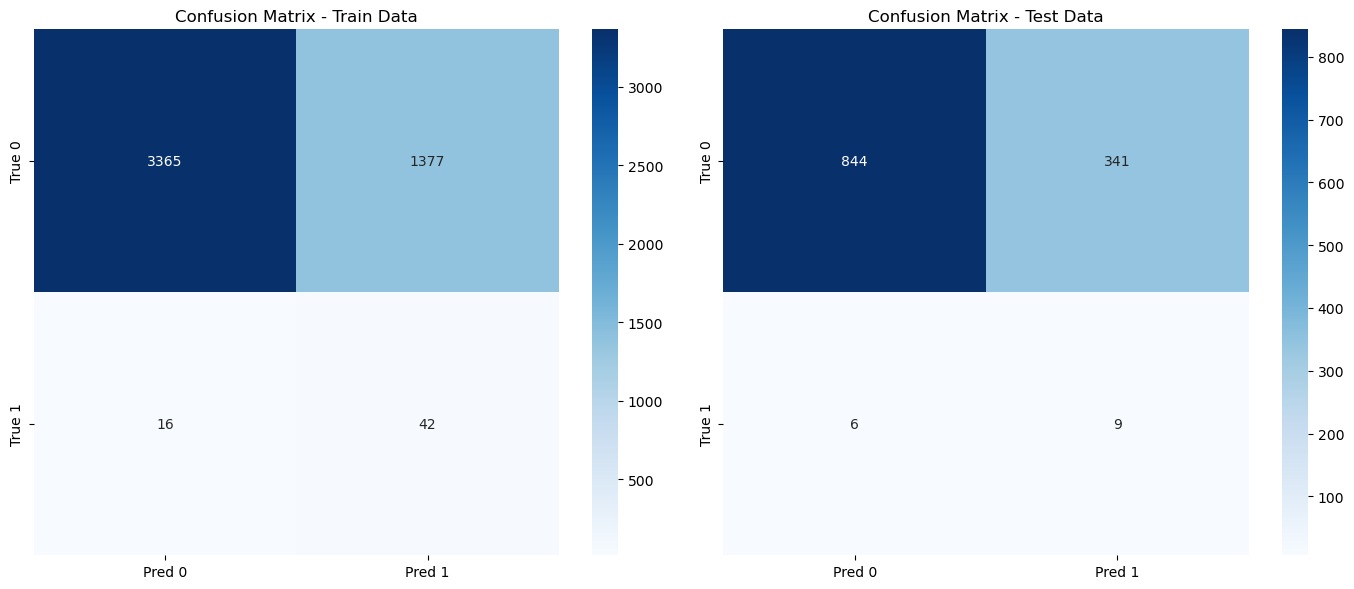

In [94]:
evaluate_model(gscv.best_estimator_, X_train, X_test, y_train, y_test)

In [95]:
model = gscv.best_estimator_

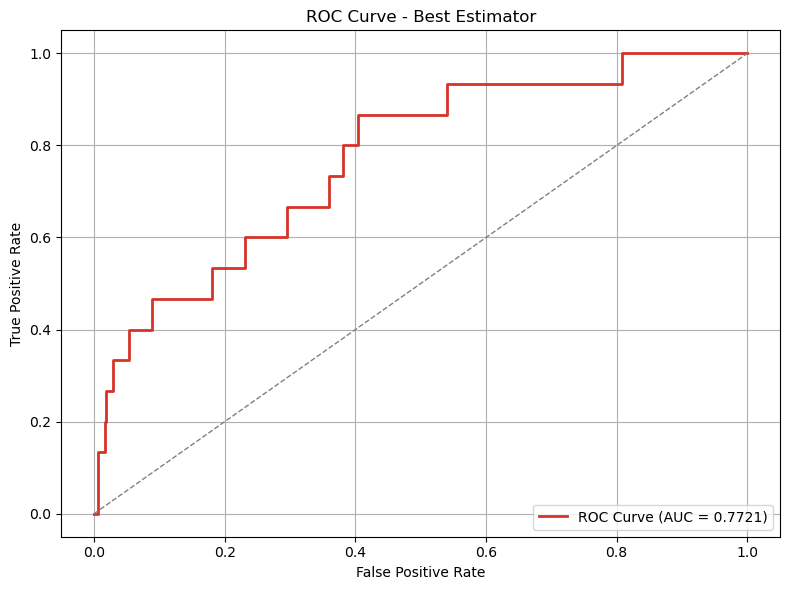

In [96]:
# Prediksi probabilitas positive class (label = 1)
y_proba = gscv.best_estimator_.predict_proba(X_test)[:, 1]

# Hitung ROC curve dan ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Visualisasi ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#d53328', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best Estimator')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# FUNGSI SCORECARD

Untuk metode fungsi score card yang saya gunakan adalah konversi hasil probabilitas dari model dari prediksi model menjadi rentang 300-850 secara linear.



$\text{Score} = \text{min\_score} + (\text{max\_score} - \text{min\_score}) \times (1 - \text{prob})$


Metode lain yang dapat digunakan adalah konversi hasil probabilitas dari model dengan fungsi logit (log-odds).

In [101]:
def scorecard_minmax(prob, min_score=300, max_score=850):
    return np.round(min_score + (max_score - min_score) * (1 - prob))

In [102]:
# Get predicted probabilities
y_prob = model.predict_proba(X_test)[:, 1]  # probability of default

In [103]:
score = scorecard_minmax(y_prob)

In [104]:
print(score[:10])  # Show first 10 scores

[776. 482. 835. 656. 727. 784. 532. 478. 535. 769.]


# SHAP

Untuk interpretasi model, metode SHAP akan digunakan, sesuai dengan ketentuan.

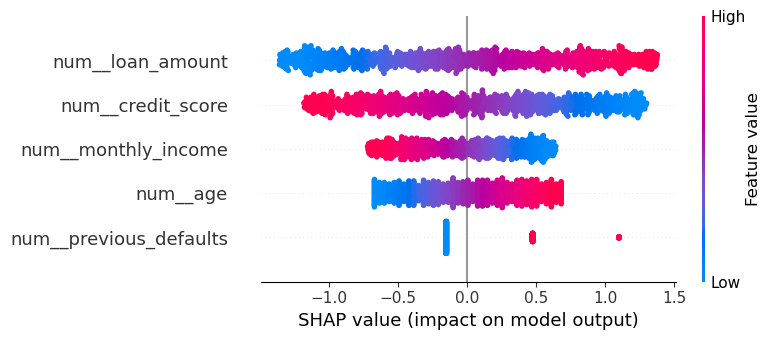

In [107]:
import shap

X_train_transformed = model.named_steps['preprocessor'].transform(X_train)

# Get the classifier
classifier = model.named_steps['classifier']

# Use SHAP for linear models (e.g., logistic regression)
explainer = shap.LinearExplainer(classifier, X_train_transformed, feature_perturbation="interventional")

# Transform test data
X_test_transformed = model.named_steps['preprocessor'].transform(X_test)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_transformed)

# Plot top 10 features
shap.summary_plot(shap_values, X_test_transformed, feature_names=model.named_steps['preprocessor'].get_feature_names_out(), max_display=10)


Berdasarkan analisis interpretabilitas menggunakan nilai SHAP, diperoleh beberapa temuan penting terkait kontribusi fitur terhadap prediksi risiko default:

- **Jumlah pinjaman** yang diajukan oleh pemohon menunjukkan hubungan positif terhadap risiko default; semakin besar jumlah pinjaman, semakin tinggi kemungkinan terjadinya gagal bayar.
- **Skor kredit** yang lebih rendah secara signifikan meningkatkan risiko default, mengindikasikan bahwa pemohon dengan riwayat kredit yang buruk cenderung memiliki probabilitas gagal bayar yang lebih tinggi.
- **Pendapatan bulanan** yang rendah berkontribusi terhadap peningkatan risiko default, mencerminkan keterbatasan kapasitas finansial pemohon dalam memenuhi kewajiban kredit.
- **Usia pemohon** yang lebih tua diasosiasikan dengan peningkatan risiko default.
- **Jumlah riwayat gagal bayar sebelumnya** (*previous defaults*) berbanding lurus dengan risiko default saat ini; pemohon dengan rekam jejak gagal bayar cenderung memiliki risiko yang lebih tinggi untuk kembali mengalami default.efault.


In [109]:
# Buat SHAP summary plot dan simpan ke file PNG
plt.figure()
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=model.named_steps['preprocessor'].get_feature_names_out(),
    max_display=10,
    show=False  # penting untuk menahan auto-show
)
plt.tight_layout()
plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches='tight')
plt.close()

# KEPUTUSAN : IDR 5 JUTA

Untuk menjawab skenario di mana seorang pemohon mengajukan pinjaman sebesar IDR 5 juta, pendekatan yang digunakan adalah dengan menghitung **rata-rata probabilitas default** dari pemohon lain yang mengajukan pinjaman dalam **rentang IDR 5 juta ±5%** (margin of error). Dengan demikian, analisis difokuskan pada subset data dengan nilai `loan_amount` antara **IDR 4,75 juta hingga IDR 5,25 juta**. Pendekatan ini bertujuan untuk memperoleh estimasi risiko default yang lebih representatif bagi kelompok pemohon dengan karakteristik serupa dari sisi jumlah pinjaman.


In [112]:
# Define the range for ±5%
lower_bound = 4750000
upper_bound = 5250000

In [113]:
X_test_applicant = X_test[(X_test['loan_amount']>=lower_bound)&(X_test['loan_amount']<=upper_bound)]

In [114]:
# Get predicted probabilities
y_prob_applicant = model.predict_proba(X_test_applicant)[:, 1]
y_prob_applicant

array([0.57752565, 0.27505189, 0.51512438, 0.10780854, 0.5443497 ,
       0.40767541, 0.16196809, 0.42476191, 0.04406771, 0.22566597,
       0.09442462, 0.25264861, 0.03935495, 0.23045819, 0.28179998,
       0.14000844, 0.24222063, 0.23400091, 0.22072972, 0.36974088,
       0.12639103, 0.32232843, 0.09829985, 0.1591582 , 0.37929859,
       0.04724664, 0.14941358, 0.679137  , 0.12669885, 0.26317332,
       0.44559252, 0.07239617, 0.17496315, 0.69827127, 0.3051985 ,
       0.21030362, 0.46913034, 0.49112779, 0.256611  , 0.14923108,
       0.21842818, 0.3990618 , 0.55673388])

In [115]:
average_proba = np.mean(y_prob_applicant)
print(f"Average probability of default: {average_proba:.4f}")

Average probability of default: 0.2834


Dari hasil perhitungan, diperoleh rata-rata probabilitas default sebesar **0,28** untuk applikasi dengan pengajuan pinjaman dalam rentang **IDR 4,75 juta hingga IDR 5,25 juta**. Keputusan untuk menyetujui atau menolak pengajuan pinjaman tentu bergantung pada **threshold (cut-off)** yang ditetapkan oleh pihak perusahaan.

Dalam proses pemodelan ini, digunakan threshold default dari modul pemodelan, yaitu **0,5**. Dengan demikian, karena nilai probabilitas default sebesar 0,28 berada di bawah cut-off tersebut, maka pengajuan pinjaman dari pemohon dengan nilai pinjaman IDR 5 juta akan dikategorikan sebagai **non-default**, dan pengajuannya dapat dianggap **layak untuk disetujui**.

Temuan ini juga sejalan dengan hasil eksplorasi data yang telah dilakukan sebelumnya, pada grafik **boxplot antara `default` dan `loan_amount`**, di mana untuk kelompok applikasi yang mengalami default, nilai pinjaman sebesar IDR 5 juta berada **di bawah kuartil pertama (Q1)**. Artinya, sebagian applikasi yang mengalami gagal bayar memiliki jumlah pinjaman yang **lebih tinggi** dari IDR 5 juta, sehingga pengajuan pinjaman 5 juta memiliki risiko yang lebih rendah untuk gagal bayar.

Proses **kalibrasi model** untuk mendapatkan threshold yang lebih optimal akan dibahas pada tes bagian berikutnya (bagian C) menggunakan pendekatan statistik melalui bahasa pemrograman **R**.

# EXPORT HASIL PREDIKSI KE .CSV

In [118]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred_proba

array([0.13386166, 0.66907973, 0.02640976, ..., 0.46723466, 0.44401332,
       0.6369334 ])

In [119]:
import pandas as pd

# Buat DataFrame dari probabilitas prediksi dan label aktual
df_val = pd.DataFrame({
    "actual": y_test,               # atau y_val jika Anda punya set khusus validasi
    "pred_prob": y_pred_proba       # ini dari model.predict_proba(X)[:, 1]
})

# Simpan ke CSV
df_val.to_csv("validation_data.csv", index=False)